This workbook define and train deep neural networks for stop sign slant angle prediction. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from __future__ import print_function
from __future__ import division

import re
import os
import sys

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

import utils

import pickle
from keras.models import load_model

Using TensorFlow backend.


utils.py loaded


## Prepare samples

In [2]:
dir = './stop-sign-heading-dataset/images' # the directory holding the sample images

Divid the samples for train, validation, and test in terms of the file names of the sample images:

In [3]:
X_train, X_validate, X_test = utils.get_filenames(dir) 

In [4]:
pickle.dump(X_test, open( "X_test.p", "wb" )) # preserve the file names for test to be executed in seperate session. 

Browse through the samples splitted:

In [5]:
map(len, (X_train, X_validate, X_test))

[3381, 966, 483]

'./stop-sign-heading-dataset/images/sign_10_2.jpg'

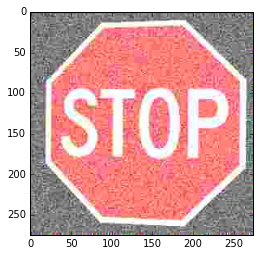

In [6]:
with open(X_train[0], 'r') as img:
    jpgdata = mpimg.imread(img)
plt.imshow(jpgdata)
X_train[0]

'./stop-sign-heading-dataset/images/sign_75_18.jpg'

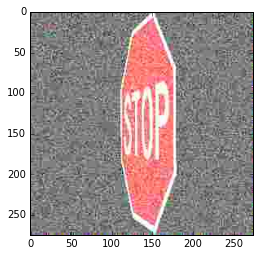

In [7]:
with open(X_validate[0], 'r') as img:
    jpgdata = mpimg.imread(img)
plt.imshow(jpgdata)
X_validate[0]

(275, 275, 3)

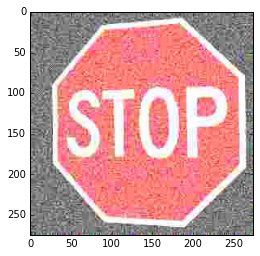

In [8]:
with open(X_test[0], 'r') as img:
    jpgdata = mpimg.imread(img)
plt.imshow(jpgdata)
X_test[0]
jpgdata.shape

## Define the network model

In [9]:
model_name = 'resnet50_regression'

input_shape = (275, 275, 3)

# load base model
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=input_shape)

# append regression layer
x = base_model.output
x = Flatten()(x)
final_output = Dense(1, activation='tanh', name='fc1')(x)

# create the new model
model = Model(inputs=base_model.input, outputs=final_output)

model.summary()

# model compilation
model.compile(loss='mean_squared_error',
              optimizer='adam')  # lr = 0.001 default
# utils.angle_error_regression

# training parameters
batch_size = 16
nb_epoch = 50 # 20 is not as good for generalization

output_folder = 'models'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# callbacks
name_proper = "{epoch:02d}-{val_loss:.2f}"
checkpointer = ModelCheckpoint(
    filepath=os.path.join(output_folder, model_name+"-"+name_proper + '.hdf5'), # model_name
    save_best_only=True
)
my_patience = 30 # used to be 2
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=my_patience, min_lr=0.00001, verbose=1)

early_stopping = EarlyStopping(patience=my_patience)

tensorboard = TensorBoard()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 275, 275, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 138, 138, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 138, 138, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 138, 138, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

## Train the network

In [10]:
# training loop
history = model.fit_generator(
    utils.DataGenerator(
        X_train,
        input_shape=input_shape,
        batch_size=batch_size,
        one_hot=False,
        preprocess_func=preprocess_input,
        shuffle=True
    ),
    steps_per_epoch=len(X_train)/batch_size,
    epochs=nb_epoch,
    validation_data=utils.DataGenerator(
        X_validate,
        input_shape=input_shape,
        batch_size=batch_size,
        one_hot=False,
        preprocess_func=preprocess_input
    ),
    validation_steps=len(X_validate)/batch_size,
    callbacks=[checkpointer, reduce_lr, early_stopping, tensorboard],
    # nb_worker=10,
    # pickle_safe=True,
    verbose=1
)

Epoch 1/50
212/211 [==============================] - 113s - loss: 0.2534 - val_loss: 1.0742
Epoch 2/50
212/211 [==============================] - 99s - loss: 0.0047 - val_loss: 0.0013
Epoch 3/50
212/211 [==============================] - 102s - loss: 0.0012 - val_loss: 5.3674e-04
Epoch 4/50
212/211 [==============================] - 97s - loss: 5.8091e-04 - val_loss: 0.0012
Epoch 5/50
212/211 [==============================] - 100s - loss: 4.8368e-04 - val_loss: 4.0822e-04
Epoch 6/50
212/211 [==============================] - 101s - loss: 3.4837e-04 - val_loss: 3.8942e-04
Epoch 7/50
212/211 [==============================] - 103s - loss: 3.1292e-04 - val_loss: 3.8500e-04
Epoch 8/50
212/211 [==============================] - 100s - loss: 2.6844e-04 - val_loss: 2.0459e-04
Epoch 9/50
212/211 [==============================] - 100s - loss: 2.5423e-04 - val_loss: 1.9252e-04
Epoch 10/50
212/211 [==============================] - 100s - loss: 2.8389e-04 - val_loss: 1.9892e-04
Epoch 11/50
212

Training loss: 0.000250059859477
Validation loss: 0.000163010462166
Learning rates: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


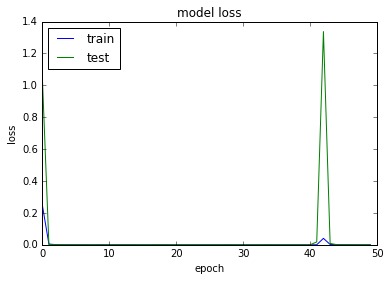

In [11]:
# list all data in history
print("Training loss: {}\nValidation loss: {}".format(history.history['loss'][-1], history.history['val_loss'][-1]))
print("Learning rates: {}".format(history.history['lr']))
# print("History keys: {}".format(history.history.keys()))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
print("Training loss: {}\nValidation loss: {}".format(history.history['loss'][-1], history.history['val_loss'][-1]))

Training loss: 0.000250059859477
Validation loss: 0.000163010462166
